## Sophie Clark

# Image Alignment and Combination

We discussed in class that _median combination_ can be used to eliminate outliers.  However, you can only combine images if they're aligned - if the tracking is bad and you try to median-combine images, you'll find that the stars disappear!  In our case, the tracking isn't _that_ bad, but the stars are still not well-aligned.

Median combining will generally eliminate cosmic rays, which is the main reason to do it.

Let's look at an example of this, starting with raw data (we haven't subtracted darks or divided by the flat field).

In this exercise, you will:
    
* Reduce & process data as in the Data Reduction notebooks
* Observe the effects of tracking and pointing errors
* Recognize where correctable errors were made during the data acquisition process
* Align images that are slightly shifted
* Use median combination to clean out cosmic rays

If you complete the bonus part of the exercise (bottom), you'll end up with this image:

<img src="RGB_Goal.png">

# Index

* [Calibration](#Calibration)
* [Flats](#Flats)
* [Q1](#Q1): Why are there hot pixels in the dark-subtracted science data?
* [Alignment](#Alignment)
* [Exercise](#Exercise)

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

In [2]:
import glob
from astropy.io import fits

In [3]:
#STUDENT ADDITION
import os
print(os.getcwd())

C:\Users\sophi\AST3722C


In [4]:
filenames = glob.glob("data_alignment/StarsNearNGCTopLeft_V*FIT")
images = [fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in filenames]
print(images)

[array([[1987.1 , 1996.4 , 2025.85, ..., 1956.1 , 1939.05, 1923.55],
       [2042.9 , 2094.05, 2015.  , ..., 1920.45, 1906.5 , 1953.  ],
       [2157.6 , 2123.5 , 2055.3 , ..., 1970.05, 1970.05, 1982.45],
       ...,
       [2041.35, 2024.3 , 2066.15, ..., 1965.4 , 1954.55, 1953.  ],
       [2069.25, 2052.2 , 2025.85, ..., 1997.95, 1973.15, 1954.55],
       [2139.  , 2049.1 , 2098.7 , ..., 1968.5 , 1929.75, 1960.75]]), array([[2024.3 , 2021.2 , 2019.65, ..., 1931.3 , 1918.9 , 1914.25],
       [2061.5 , 2063.05, 2078.55, ..., 1908.05, 1923.55, 2024.3 ],
       [2114.2 , 2106.45, 2086.3 , ..., 1963.85, 1915.8 , 1948.35],
       ...,
       [2047.55, 2038.25, 1994.85, ..., 1920.45, 1926.65, 1966.95],
       [2061.5 , 2055.3 , 2030.5 , ..., 1951.45, 2002.6 , 1993.3 ],
       [2059.95, 2004.15, 2069.25, ..., 1925.1 , 1954.55, 1928.2 ]]), array([[2047.55, 2005.7 , 1985.55, ..., 1974.7 , 1937.5 , 1949.9 ],
       [2046.  , 2106.45, 2022.75, ..., 1897.2 , 1923.55, 1962.3 ],
       [2159.15, 21

In [5]:
raw_median_combined_images = np.median(images,
                                       axis=0)

Text(0.5, 1.0, 'Median Stack')

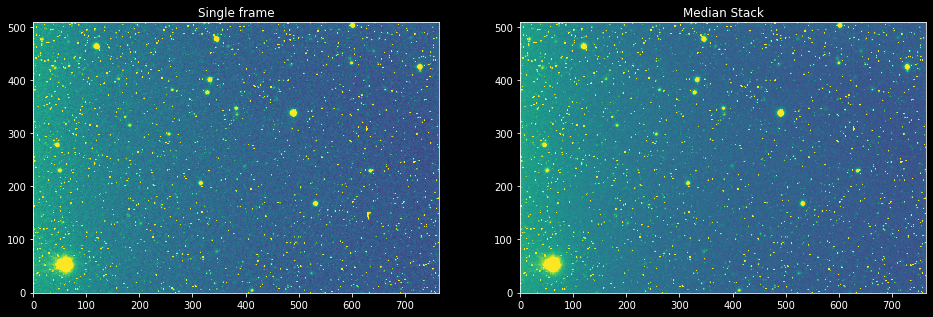

In [6]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(images[1], origin='lower', vmax=2170, vmin=1860)
pl.title("Single frame")
pl.subplot(1,2,2).imshow(raw_median_combined_images, origin='lower', vmax=2170, vmin=1860)
pl.title("Median Stack")


Look closely at the region around x$\sim$620, y$\sim$150

Text(0.5, 1.0, 'Median Stack')

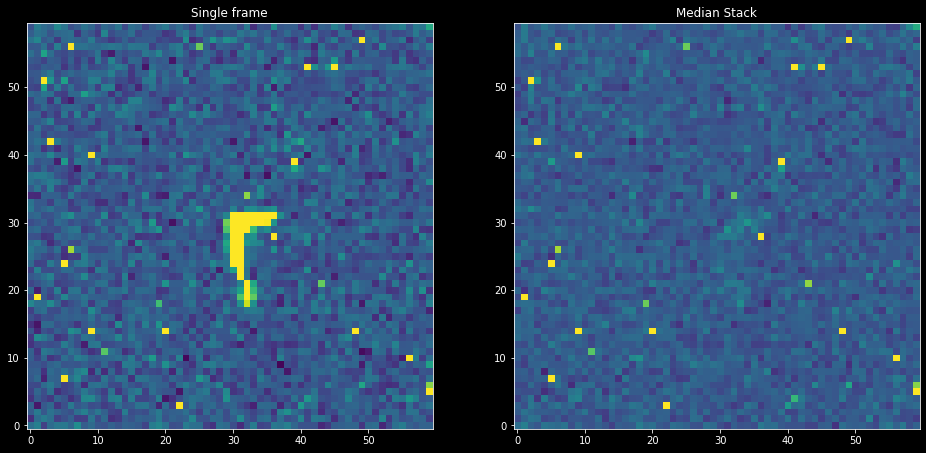

In [7]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(images[1][120:180,600:660], origin='lower', vmax=2170, vmin=1860)
pl.title("Single frame")

pl.subplot(1,2,2).imshow(raw_median_combined_images[120:180,600:660], origin='lower', vmax=2170, vmin=1860)
pl.title("Median Stack")


Note that the cosmic ray hit has (almost) completely disappeared!

Now let's look closely at a star, comparing the three frames and their median.

Text(0.5, 1.0, 'Median Stack')

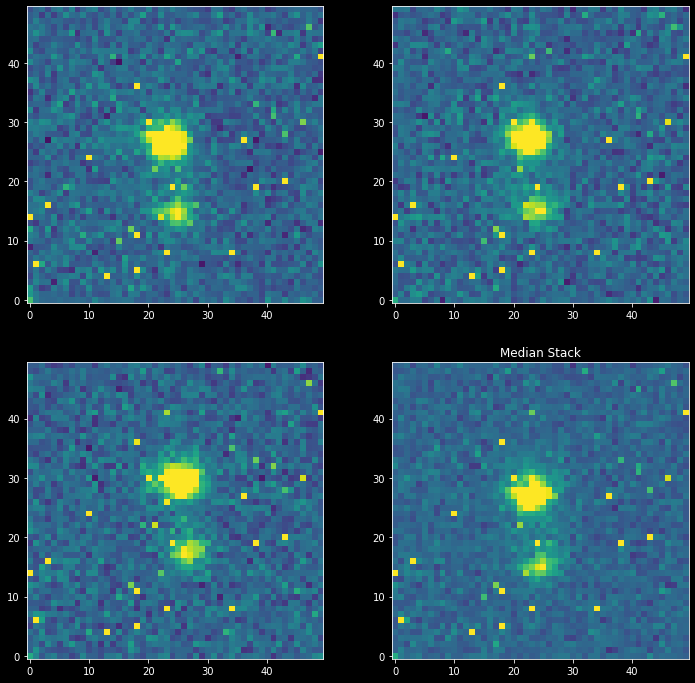

In [8]:
pl.figure(figsize=(12,12))

for ii in range(3):
    pl.subplot(2,2,ii+1).imshow(images[ii][320:370,360:410], origin='lower', vmax=2170, vmin=1860)

pl.subplot(2,2,4).imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2170, vmin=1860)
pl.title("Median Stack")


If we mark an 'x' at pixel x,y = 385,345, we can see how the stars move around a little.  

However, since we're using small cutouts, the bottom-left corner has moved!  Therefore, we don't plot at x=385, y=345, we plot at (x-x0) = (385-360) = 25, (y-y0) = (345-320) = 25.  In other words, the X we're plotting is _relative_ to the bottom-left corner.

Text(0.5, 1.0, 'Median Stack')

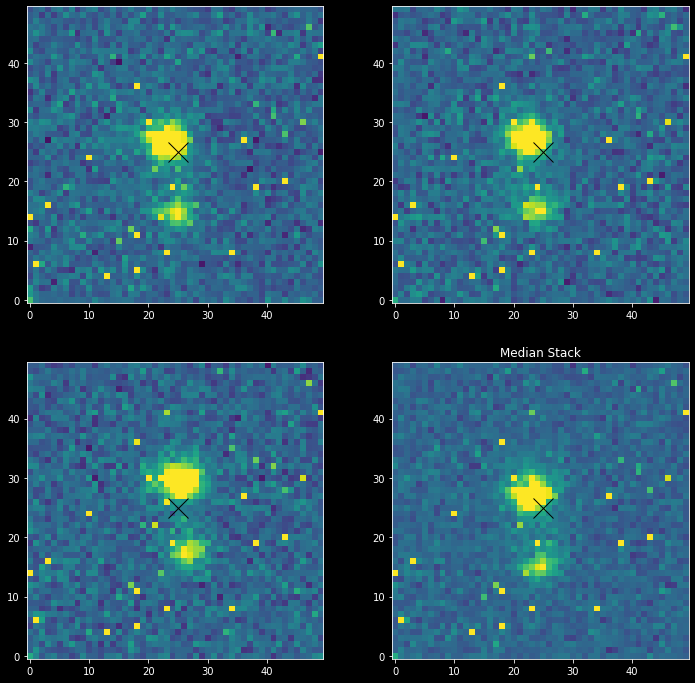

In [9]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(images[ii][320:370,360:410], origin='lower', vmax=2170, vmin=1860)
    ax.plot(25, 25, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2170, vmin=1860)
ax.plot(25, 25, 'kx', markersize=20)

ax.set_title("Median Stack")


The stars are jittering around!

You can also see that the median image is a little fainter than it should be.

We can correct for these errors, but we do first have to calibrate the data.

# Calibration

[Index](#Index)

In [10]:
dark_30s_filenames = glob.glob('data_alignment/Dark_30s_02*FIT')
flat_v_filenames = glob.glob('data_alignment/Flats_V_10s_*FIT')
bias_filenames = glob.glob('data_alignment/Bias_02*FIT')

In [11]:
bias_filenames

['data_alignment\\Bias_02_12_2020001.FIT',
 'data_alignment\\Bias_02_12_2020002.FIT',
 'data_alignment\\Bias_02_12_2020003.FIT',
 'data_alignment\\Bias_02_12_2020004.FIT',
 'data_alignment\\Bias_02_12_2020005.FIT',
 'data_alignment\\Bias_02_12_2020006.FIT',
 'data_alignment\\Bias_02_12_2020007.FIT',
 'data_alignment\\Bias_02_12_2020008.FIT',
 'data_alignment\\Bias_02_12_2020009.FIT',
 'data_alignment\\Bias_02_12_2020010.FIT']

In [12]:
dark_30s_filenames

['data_alignment\\Dark_30s_02_12_2020001.FIT',
 'data_alignment\\Dark_30s_02_12_2020002.FIT',
 'data_alignment\\Dark_30s_02_12_2020003.FIT',
 'data_alignment\\Dark_30s_02_12_2020004.FIT',
 'data_alignment\\Dark_30s_02_12_2020005.FIT',
 'data_alignment\\Dark_30s_02_12_2020006.FIT',
 'data_alignment\\Dark_30s_02_12_2020007.FIT',
 'data_alignment\\Dark_30s_02_12_2020008.FIT',
 'data_alignment\\Dark_30s_02_12_2020009.FIT',
 'data_alignment\\Dark_30s_02_12_2020010.FIT']

We median-stack all the darks & biases to eliminate their cosmic rays:

In [13]:
median_bias = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
median_dark_30s = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in dark_30s_filenames], axis=0)

In [14]:
std_bias = np.std([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
print(f"median and mean readnoise: {np.median(std_bias):0.1f}, {np.mean(std_bias):0.1f} +/- {np.std(std_bias):0.1f}")

median and mean readnoise: 15.4, 15.6 +/- 3.8


Should be 15.4, 15.6 +/- 3.8

In [15]:
median_dark_current_rate = np.median((median_dark_30s - median_bias) / 30)
print(f"Dark current rate: {median_dark_current_rate:0.2f}, median dark cts in 30s: {np.median(median_dark_30s - median_bias):0.1f}")

Dark current rate: 0.21, median dark cts in 30s: 6.2


Should be "Dark current rate: 0.21, median dark cts in 30s: 6.2"

# Flats

[Index](#Index)

We average the flats instead of median combining because the flats are taken in variable lighting.  If we took the median over several frames, and the sky was getting brighter from one frame to the next, the median would just select the middle frame and we'd get no benefits from the repeat exposures.

In [16]:
average_flat_v = np.mean([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in flat_v_filenames], axis=0)

For the flats, we can subtract only the bias (if you have them, it's better to subtract darks of the same exposure time, though).

In [17]:
average_flat_v_biassub = average_flat_v - median_bias

Then we mean-normalize the flat:

In [18]:
average_flat_v_biassub_norm = average_flat_v_biassub / average_flat_v_biassub.mean()

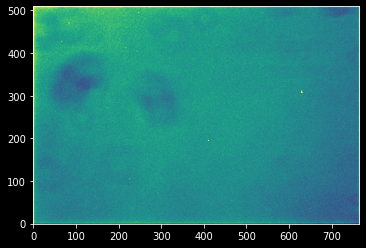

In [19]:
pl.imshow(average_flat_v_biassub_norm, origin='lower', vmin=0.95, vmax=1.05)

The science images are 30s exposures, so we subtract the median 30s dark from each of those (median because darks can have cosmic ray hits).

Then, we divide by the normalized flat

In [20]:
darksub_science_images = [im - median_dark_30s for im in images]
flat_darksub_science_images = [im / average_flat_v_biassub_norm for im in darksub_science_images]

In [21]:
processed_median_combined_images = np.median(flat_darksub_science_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

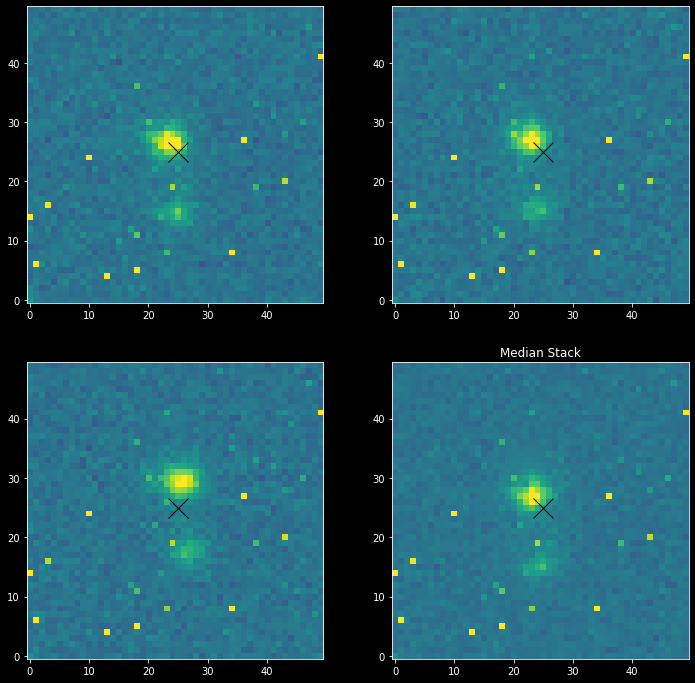

In [22]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(25, 25, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(25, 25, 'kx', markersize=20)

ax.set_title("Median Stack")

The processed images above don't look particularly good - there are a bunch of hot pixels!

Why did this happen?  

Hints:
 * You can inspect the headers of the images to see some information about how the data were taken.
 * What factors affect how much dark current the CCD records?
 * Notice that the individual images (each of the flat-field-corrected, dark-subtracted science images) exhibits hot pixels.

In [23]:
header = fits.getheader('data_alignment/StarsNearNGCTopLeft_V_30s_02_12_2020001.FIT')
print(header)
print()
header_1 = fits.getheader('data_alignment/Dark_30s_02_12_2020001.FIT')
print(header_1)

SIMPLE  =                    T /                                                BITPIX  =                   16 /                                                NAXIS   =                    2 /                                                NAXIS1  =                  765 /                                                NAXIS2  =                  510 /                                                OBJECT  = '        '           /                                                TELESCOP= '12-inch Meade LX200'                                                 INSTRUME= 'SBIG ST-402'                                                         OBSERVER= 'Photometry Group 4'                                                  DATE-OBS= '2020-02-13T02:00:38.000' / GMT START OF EXPOSURE [WIN]               BZERO   = +3.276800000000E+004 /                                                BSCALE  = +1.000000000000E+000 /                                                EXPTIME = +3.000000000000E+001 / EXPOSUR

## Q1

[Index](#Index)

Why are there hot pixels in the dark-subtracted science data?

Answer: We can see from inspecting the header of a V-band image and one of the dark exposures that the two images were taken at about a 7 degrees Celsius difference. Because we know that dark current and hot pixels are caused by a greater amount of thermal energy in the CCD, the V-band image would thus have more hot pixels, and thus subtracting the darks (which would not have such severe hot pixels) would not cause a significant difference in the counts of the hot pixels. 

# Alignment
[Index](#Index)

The next step is to align the images.

To do this, we estimate how far each image is shifted from each other.

As a first pass, we can just "eyeball" the offset by looking at the images:

Text(0.5, 1.0, 'Median Stack')

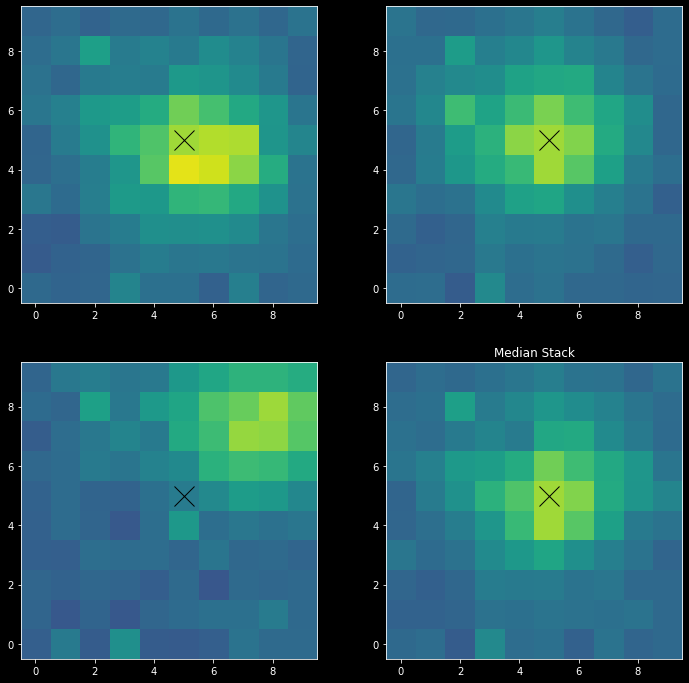

In [24]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

We can see that the positions are off by a few pixels each:
* the top-left image is about 3 pixels left and 3 pixels down from the top-right image
* the bottom-left image is about 1 pixel up from the top-right image, but they are aligned left-right

Note that there is not a perfect "center" pixel, just approximate ones!

To add the images together (or median combine them), they all have to be exactly the same size.

How can we shift the images?  There are two ways we can consider:

(1) We could crop each image so they're the same size, then stack them on top of each other.

(2) We could "roll" the images such that the leftmost pixel becomes the rightmost, and every other pixel shifts by 1 space from right-to-left (or, by $n$ spaces).  If we do this, the edges of the image will be useless - we can crop them later.


We'll go with the 'roll' approach:

In [25]:
# for image zero, the top-left image, we "roll" back three pixels in each dimension
im0 = np.roll(np.roll(flat_darksub_science_images[2], -3, axis=0), -3, axis=1)
im1 = flat_darksub_science_images[1] # this is our "reference image", it stays put

# the bottom-left image, im2, only needs to "roll" on the Y-axis
im2 = np.roll(flat_darksub_science_images[0], 1, axis=0)
rolled_images = [im0,im1,im2]
v_rolled_median = np.median(rolled_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

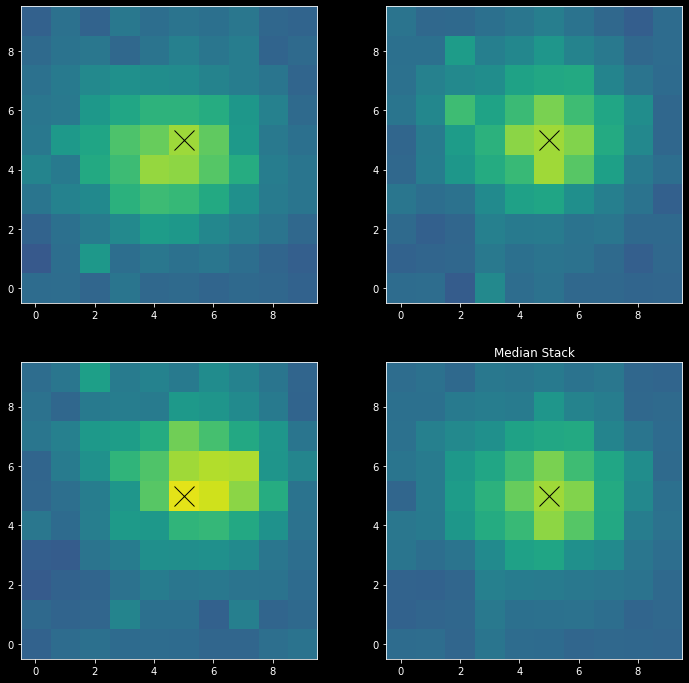

In [26]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(v_rolled_median[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

The alignment is better, but not perfect.

We can see more interesting effects if we zoom back out a little:

Text(0.5, 1.0, 'Median Stack')

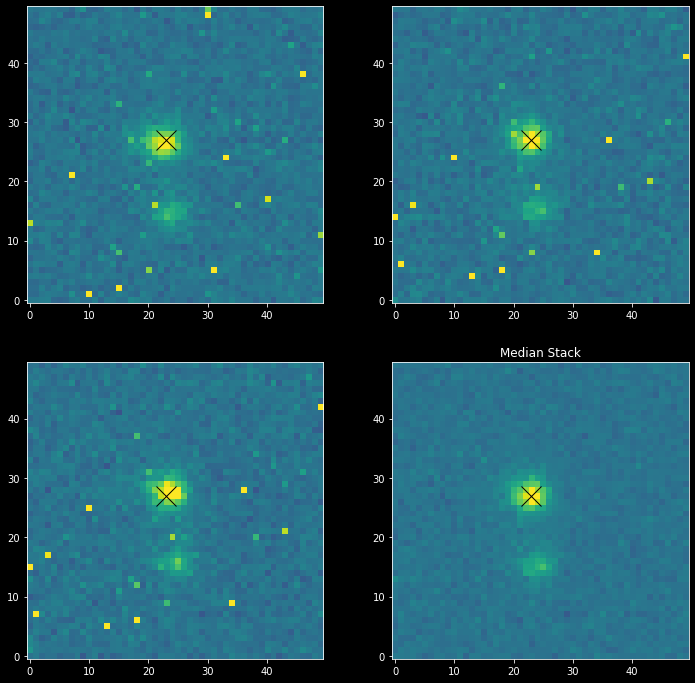

In [27]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(v_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

ax.set_title("Median Stack")

Let's compare the original, raw median to the new, rolled median:

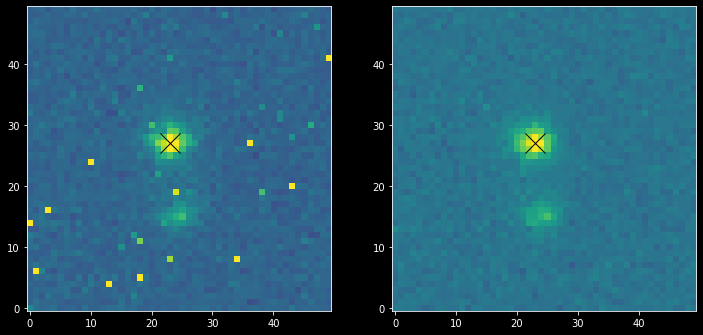

In [28]:
pl.figure(figsize=(12,6))
ax = pl.subplot(1,2,1)
ax.imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2400, vmin=1750)
ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(1,2,2)
ax.imshow(v_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)



Note the biggest difference: those hot pixels are gone!
    
Because the hot pixels are all at the same location, and we shifted the images, the median combination removed them all as they are all outliers!

## Exercise

[Index](#Index)

Repeat the above process (i.e., shifting & stacking) for the I-band data.

Use the V-band median image as your reference!

In [29]:
filenames = glob.glob("data_alignment/StarsNearNGCTopLeft_I*FIT")
images = [fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in filenames]
print(images)

[array([[1872.4 , 1867.75, 1918.9 , ..., 1802.65, 1779.4 , 1816.6 ],
       [1883.25, 1872.4 , 1880.15, ..., 1794.9 , 1798.  , 1746.85],
       [1973.15, 1948.35, 1881.7 , ..., 1794.9 , 1842.95, 1830.55],
       ...,
       [1884.8 , 1928.2 , 1861.55, ..., 1808.85, 1801.1 , 1794.9 ],
       [1878.6 , 1917.35, 1866.2 , ..., 1802.65, 1774.75, 1794.9 ],
       [1957.65, 1892.55, 1908.05, ..., 1811.95, 1839.85, 1787.15]]), array([[1864.65, 1855.35, 1878.6 , ..., 1774.75, 1776.3 , 1827.45],
       [1858.45, 1912.7 , 1872.4 , ..., 1765.45, 1805.75, 1838.3 ],
       [2010.35, 1951.45, 1923.55, ..., 1852.25, 1771.65, 1808.85],
       ...,
       [1849.15, 1889.45, 1906.5 , ..., 1825.9 , 1816.6 , 1777.85],
       [1892.55, 1844.5 , 1897.2 , ..., 1793.35, 1816.6 , 1824.35],
       [1937.5 , 1878.6 , 1897.2 , ..., 1819.7 , 1808.85, 1830.55]]), array([[1873.95, 1881.7 , 1900.3 , ..., 1779.4 , 1737.55, 1773.2 ],
       [1883.25, 1864.65, 1852.25, ..., 1794.9 , 1804.2 , 1798.  ],
       [1990.2 , 19

In [30]:
raw_median_combined_images = np.median(images,
                                       axis=0)

Text(0.5, 1.0, 'Median Stack')

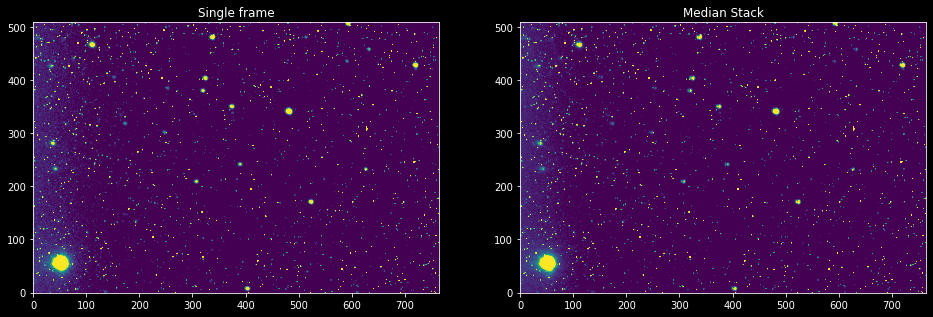

In [31]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(images[1], origin='lower', vmax=2170, vmin=1860)
pl.title("Single frame")
pl.subplot(1,2,2).imshow(raw_median_combined_images, origin='lower', vmax=2170, vmin=1860)
pl.title("Median Stack")

In [32]:
dark_30s_filenames = glob.glob('data_alignment/Dark_30s_02*FIT')
flat_i_filenames = glob.glob('data_alignment/Flats_I_10s_*FIT')
bias_filenames = glob.glob('data_alignment/Bias_02*FIT')

In [33]:
median_bias = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
median_dark_30s = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in dark_30s_filenames], axis=0)

In [34]:
std_bias = np.std([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
print(f"median and mean readnoise: {np.median(std_bias):0.1f}, {np.mean(std_bias):0.1f} +/- {np.std(std_bias):0.1f}")

median and mean readnoise: 15.4, 15.6 +/- 3.8


In [35]:
median_dark_current_rate = np.median((median_dark_30s - median_bias) / 30)
print(f"Dark current rate: {median_dark_current_rate:0.2f}, median dark cts in 30s: {np.median(median_dark_30s - median_bias):0.1f}")

Dark current rate: 0.21, median dark cts in 30s: 6.2


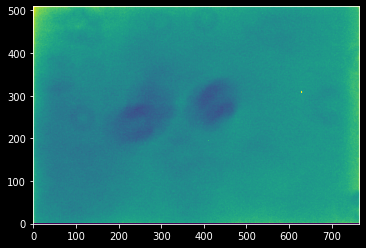

In [36]:
average_flat_i = np.mean([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in flat_i_filenames], axis=0)
average_flat_i_biassub = average_flat_i - median_bias
average_flat_i_biassub_norm = average_flat_i_biassub / average_flat_i_biassub.mean()
pl.imshow(average_flat_i_biassub_norm, origin='lower', vmin=0.95, vmax=1.05)

In [37]:
darksub_science_images = [im - median_dark_30s for im in images]
flat_darksub_science_images = [im / average_flat_i_biassub_norm for im in darksub_science_images]

In [38]:
processed_median_combined_images = np.median(flat_darksub_science_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

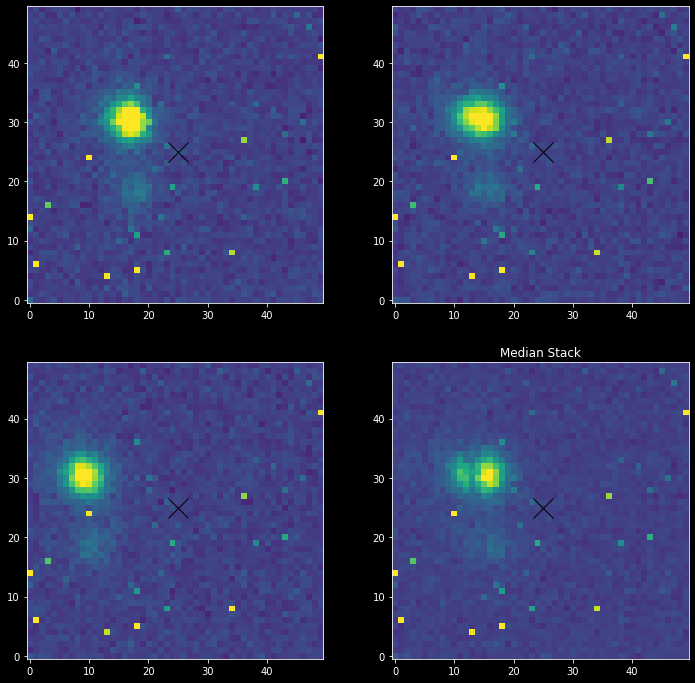

In [39]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(25, 25, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(25, 25, 'kx', markersize=20)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

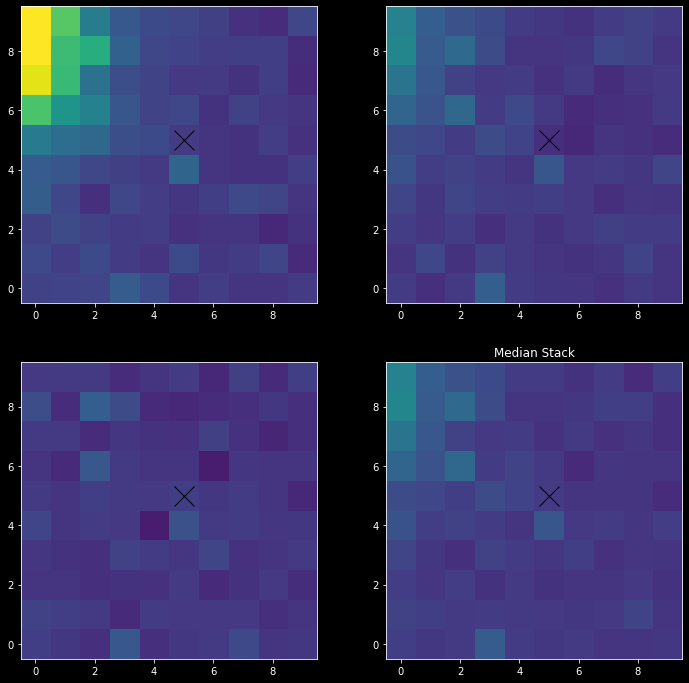

In [40]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

In [41]:
im0 = np.roll(np.roll(flat_darksub_science_images[2], -3, axis=0), 14, axis=1)

im1 = np.roll(np.roll(flat_darksub_science_images[1], -3, axis=0), 8, axis=1)

im2 = np.roll(np.roll(flat_darksub_science_images[0], -3, axis=0), 6, axis=1)
rolled_images = [im0,im1,im2]
i_rolled_median = np.median(rolled_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

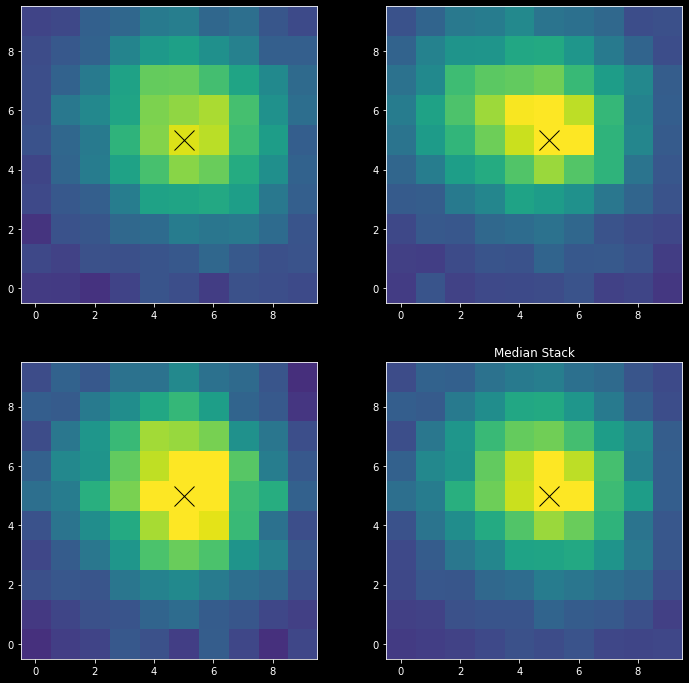

In [42]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(i_rolled_median[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

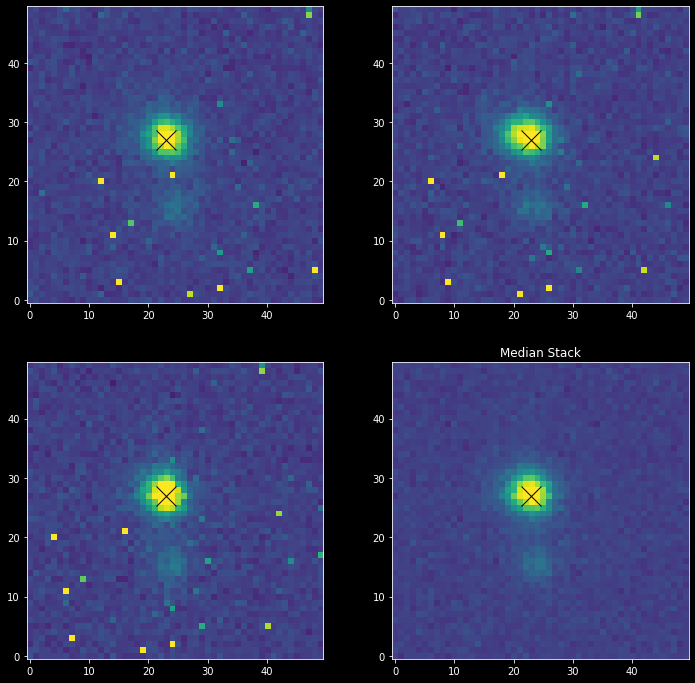

In [43]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(i_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

ax.set_title("Median Stack")

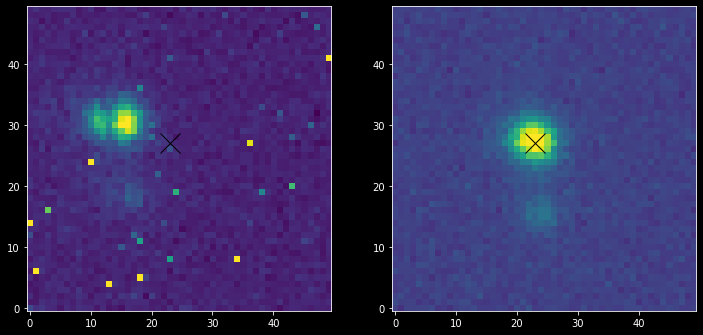

In [44]:
pl.figure(figsize=(12,6))
ax = pl.subplot(1,2,1)
ax.imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2400, vmin=1750)
ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(1,2,2)
ax.imshow(i_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

# BONUS exercise: Repeat again for B-band

Then, make a 3-color image

(this is extra-credit)

In [45]:
filenames = glob.glob("data_alignment/StarsNearNGCTopLeft_B*FIT")
images = [fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in filenames]
print(images)

[array([[1920.45, 1909.6 , 1875.5 , ..., 1813.5 , 1818.15, 1822.8 ],
       [1898.75, 1920.45, 1918.9 , ..., 1849.15, 1855.35, 1821.25],
       [1996.4 , 1973.15, 1923.55, ..., 1808.85, 1813.5 , 1825.9 ],
       ...,
       [1917.35, 1878.6 , 1923.55, ..., 1835.2 , 1816.6 , 1798.  ],
       [1937.5 , 1880.15, 1869.3 , ..., 1771.65, 1839.85, 1829.  ],
       [1894.1 , 1891.  , 1917.35, ..., 1853.8 , 1830.55, 1779.4 ]]), array([[1886.35, 1900.3 , 1872.4 , ..., 1822.8 , 1824.35, 1822.8 ],
       [1911.15, 1878.6 , 1914.25, ..., 1794.9 , 1822.8 , 1804.2 ],
       [2005.7 , 1954.55, 1935.95, ..., 1816.6 , 1816.6 , 1815.05],
       ...,
       [1914.25, 1922.  , 1934.4 , ..., 1844.5 , 1807.3 , 1824.35],
       [1901.85, 1931.3 , 1932.85, ..., 1808.85, 1829.  , 1801.1 ],
       [1897.2 , 1895.65, 1931.3 , ..., 1815.05, 1844.5 , 1804.2 ]]), array([[1922.  , 1898.75, 1901.85, ..., 1864.65, 1827.45, 1825.9 ],
       [1894.1 , 1906.5 , 1900.3 , ..., 1839.85, 1830.55, 1804.2 ],
       [2015.  , 19

In [46]:
raw_median_combined_images = np.median(images, axis=0)

Text(0.5, 1.0, 'Median Stack')

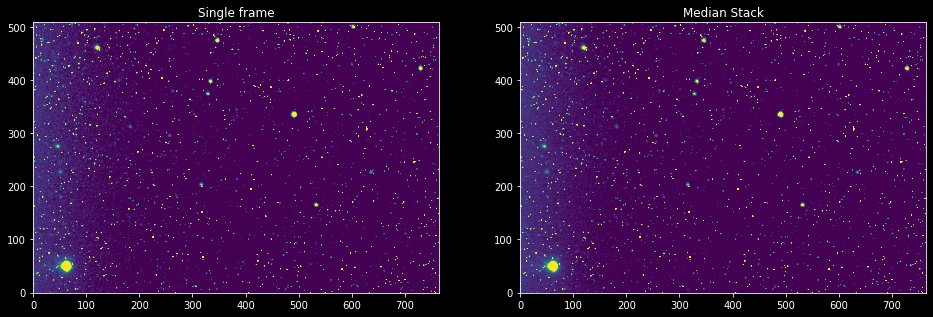

In [47]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(images[1], origin='lower', vmax=2170, vmin=1860)
pl.title("Single frame")
pl.subplot(1,2,2).imshow(raw_median_combined_images, origin='lower', vmax=2170, vmin=1860)
pl.title("Median Stack")

In [48]:
dark_30s_filenames = glob.glob('data_alignment/Dark_30s_02*FIT')
flat_b_filenames = glob.glob('data_alignment/Flats_B_10s_*FIT')
bias_filenames = glob.glob('data_alignment/Bias_02*FIT')

In [49]:
median_bias = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
median_dark_30s = np.median([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in dark_30s_filenames], axis=0)

In [50]:
std_bias = np.std([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in bias_filenames], axis=0)
print(f"median and mean readnoise: {np.median(std_bias):0.1f}, {np.mean(std_bias):0.1f} +/- {np.std(std_bias):0.1f}")

median and mean readnoise: 15.4, 15.6 +/- 3.8


In [51]:
median_dark_current_rate = np.median((median_dark_30s - median_bias) / 30)
print(f"Dark current rate: {median_dark_current_rate:0.2f}, median dark cts in 30s: {np.median(median_dark_30s - median_bias):0.1f}")

Dark current rate: 0.21, median dark cts in 30s: 6.2


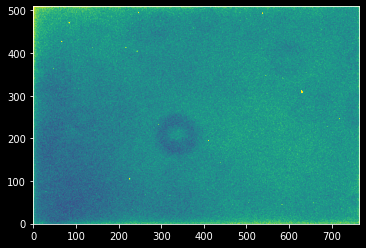

In [52]:
average_flat_b = np.mean([fits.getdata(fn)*fits.getheader(fn)['EGAIN'] for fn in flat_b_filenames], axis=0)
average_flat_b_biassub = average_flat_b - median_bias
average_flat_b_biassub_norm = average_flat_b_biassub / average_flat_b_biassub.mean()
pl.imshow(average_flat_b_biassub_norm, origin='lower', vmin=0.95, vmax=1.05)

In [53]:
darksub_science_images = [im - median_dark_30s for im in images]
flat_darksub_science_images = [im / average_flat_b_biassub_norm for im in darksub_science_images]

In [54]:
processed_median_combined_images = np.median(flat_darksub_science_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

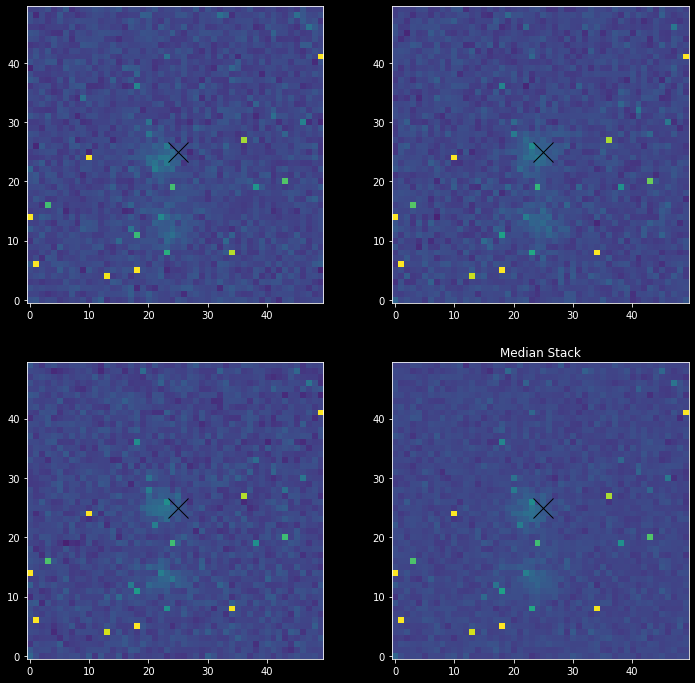

In [55]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(25, 25, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(25, 25, 'kx', markersize=20)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

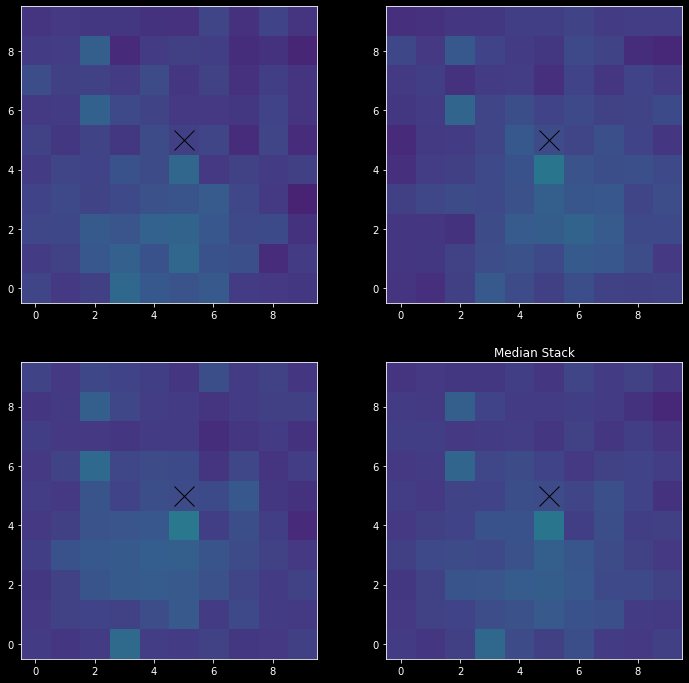

In [56]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(flat_darksub_science_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(processed_median_combined_images[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

In [57]:
im0 = np.roll(np.roll(flat_darksub_science_images[2], 0, axis=0), 1, axis=1)

im1 = flat_darksub_science_images[1]

im2 = np.roll(np.roll(flat_darksub_science_images[0], 1, axis=0), 1, axis=1)
rolled_images = [im0,im1,im2]
b_rolled_median = np.median(rolled_images, axis=0)

Text(0.5, 1.0, 'Median Stack')

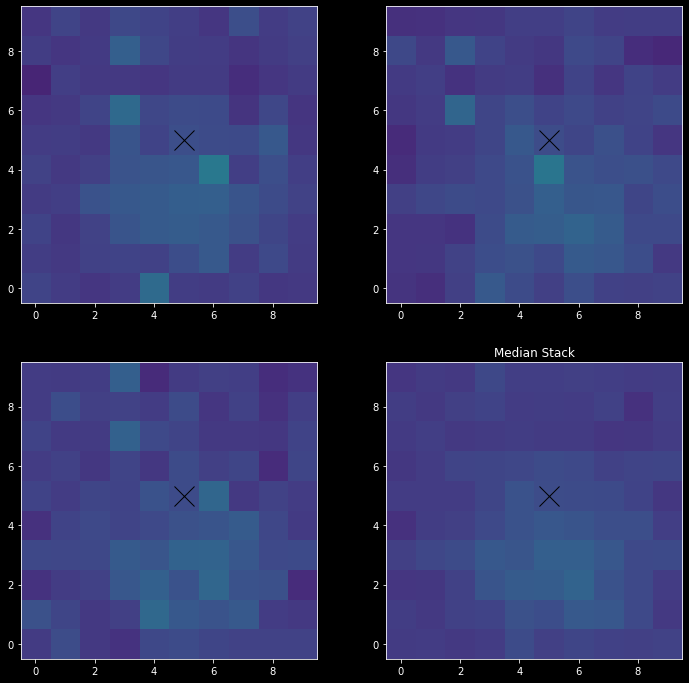

In [58]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][342:352,378:388], origin='lower', vmax=930, vmin=0)
    ax.plot(5, 5, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(b_rolled_median[342:352,378:388], origin='lower', vmax=930, vmin=0)
ax.plot(5, 5, 'kx', markersize=20)

ax.set_title("Median Stack")

Text(0.5, 1.0, 'Median Stack')

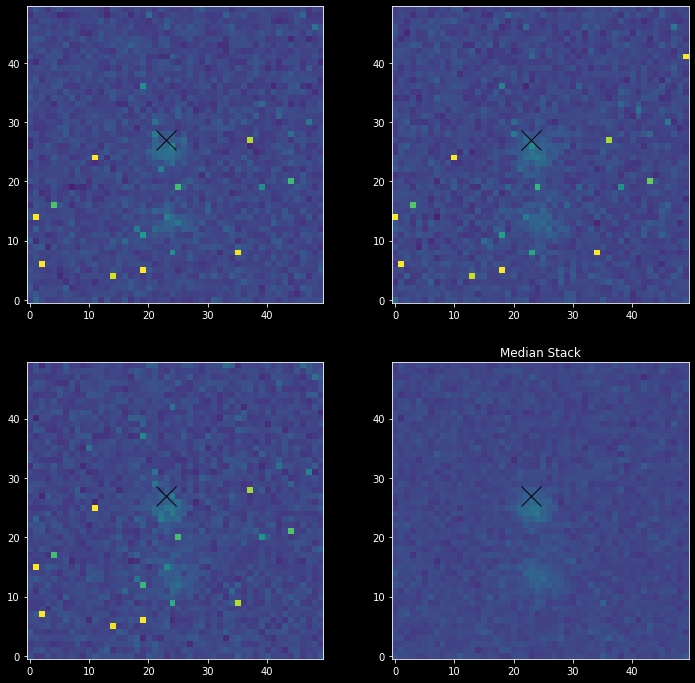

In [59]:
pl.figure(figsize=(12,12))

for ii in range(3):
    ax = pl.subplot(2,2,ii+1)
    ax.imshow(rolled_images[ii][320:370,360:410], origin='lower', vmax=750, vmin=0)
    ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(2,2,4)
ax.imshow(b_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

ax.set_title("Median Stack")

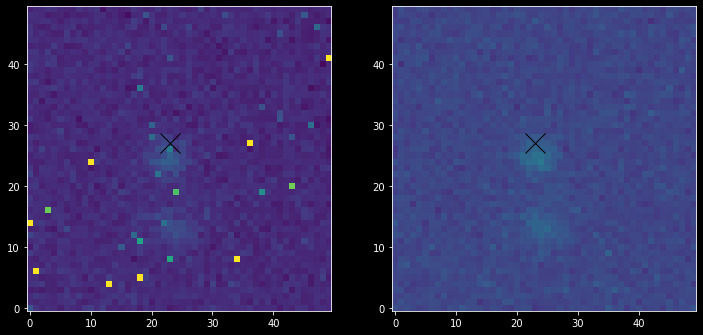

In [60]:
pl.figure(figsize=(12,6))
ax = pl.subplot(1,2,1)
ax.imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2400, vmin=1750)
ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(1,2,2)
ax.imshow(b_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

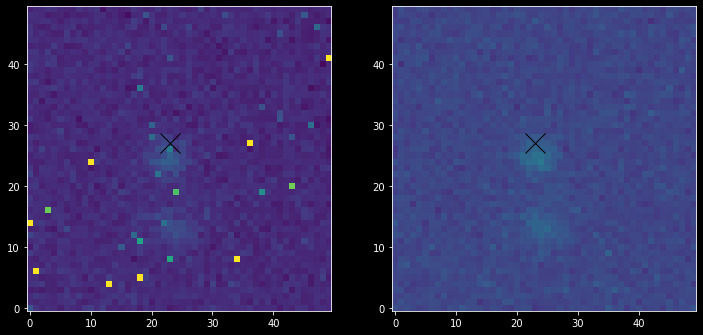

In [61]:
pl.figure(figsize=(12,6))
ax = pl.subplot(1,2,1)
ax.imshow(raw_median_combined_images[320:370,360:410], origin='lower', vmax=2400, vmin=1750)
ax.plot(23, 27, 'kx', markersize=20)

ax = pl.subplot(1,2,2)
ax.imshow(b_rolled_median[320:370,360:410], origin='lower', vmax=750, vmin=0)
ax.plot(23, 27, 'kx', markersize=20)

In [62]:
import pylab as plt
import matplotlib
import numpy as np
#visual is green, infrared is red, and blue is blue (obviously)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


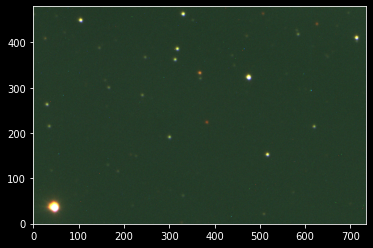

In [64]:
# red factor = 0.00290979294; green factor = 0.00254774114; blue factor = 0.00593643235
red = i_rolled_median[15:495,15:750]*0.001
green = v_rolled_median[15:495,15:750]*0.0008
blue = b_rolled_median[15:495,15:750]*0.001
plt.imshow(np.dstack([red, green, blue]))